In [1]:
#import all the things we need
%matplotlib inline
from qutip import*
import numpy as np

from scipy import *

import matplotlib.pyplot as plt

import time

# Here we import bostix
from bostix.solver import DPSolver

# Decay Test

No pump, single mode

In [2]:
data = DPSolver(dim=[4], ham=[], col=[(1, "a")])
print(data)

DPSolver(dim=[4], ham=[], col=[(1, [2])], _ep_deriver=None, _dp_solver=None)


In [3]:
matrix_mapper = data.solve(2, 1e-5, alpha=0.5)
rho_ss=np.mat(matrix_mapper.row_rho().as_2d_list())
print("The density matrix:")
print(rho_ss)
print("The population:")
print(matrix_mapper.avg_moment([1]))

The density matrix:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
The population:
0j


# Single Mode Pump Test

Pump is applied, with detuning, and the Hamiltonian can be written as
$$
\hat{H}=E(\hat{a}+\hat{a}^\dagger)+\Delta\hat{a}^\dagger\hat{a}
$$

## QuTip

In [4]:
E=0.3
kappa=1
delta=0.5;
Na=3; 
a=destroy(Na)
H=E*(a.dag()+a)+delta*a.dag()*a
psi0=basis(Na,0)
track=[a.dag()*a]
c_ops=[]
c_ops.append(np.sqrt(kappa)*a)

In [5]:
tlist=np.linspace(0,15,1000)
opts = Options()
opts.store_states=True
ts=time.time()
output=mesolve(H,psi0,tlist,c_ops,track,options=opts)
te=time.time()
t_qutip_f=te-ts

Text(0, 0.5, '$N_a$')

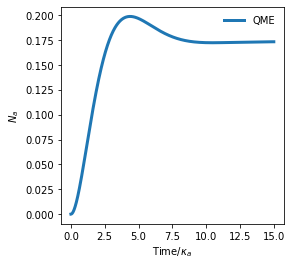

In [6]:
fig, axes = plt.subplots(1,1,figsize=(4,4))

#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes.plot(tlist, output.expect[0],linewidth=3,label="QME")

axes.legend(loc=0,ncol=1,frameon=False)

axes.set_xlabel('Time/'+r'$\kappa_a$')
axes.set_ylabel(r'$N_a$')

In [7]:
ts=time.time()
rho_ss_qutip=steadystate(H,c_ops)
te=time.time()
t_qutip=te-ts
print("Time cost:"+str(t_qutip_f)+'s')
print("Time cost:"+str(t_qutip)+'s')

Time cost:0.06600022315979004s
Time cost:0.1880505084991455s


In [8]:
print("The density matrix:")
print(output.states[-1])
print(rho_ss_qutip)

The density matrix:
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 8.38910636e-01-1.56314258e-18j -2.47910401e-01+2.48091510e-01j
  -6.44795718e-05-9.65373685e-02j]
 [-2.47910401e-01-2.48091510e-01j  1.48802476e-01+3.96092859e-18j
  -2.89529191e-02+2.89693308e-02j]
 [-6.44795718e-05+9.65373685e-02j -2.89529191e-02-2.89693308e-02j
   1.22868877e-02-2.71113140e-18j]]
Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 8.38920067e-01+0.j         -2.47990293e-01+0.24799029j
   7.38640210e-18-0.09652603j]
 [-2.47990293e-01-0.24799029j  1.48794176e-01+0.j
  -2.89578084e-02+0.02895781j]
 [ 7.38640210e-18+0.09652603j -2.89578084e-02-0.02895781j
   1.22857576e-02+0.j        ]]


In [9]:
population_qutip=expect(rho_ss_qutip,a.dag()*a)
print("The population:")
print(population_qutip)

The population:
0.17336569088427117


## Bostix

In [10]:
H=[[E,"a"],[E,"A"],[delta,"Aa"]]
c_ops=[[kappa, "a"]]

In [11]:
data = DPSolver(dim=[Na], ham=H, col=c_ops)
print(data)

DPSolver(dim=[3], ham=[(0.3, [2]), (0.3, [1]), (0.5, [1, 2])], col=[(1, [2])], _ep_deriver=None, _dp_solver=None)


In [12]:
ts=time.time()
matrix_mapper = data.solve(1000, 1e-5, alpha=0.5)
te=time.time()
t_bostix=te-ts
print("Time cost:"+str(t_bostix)+'ms')

Time cost:0.0009975433349609375ms


In [13]:
rho_ss=np.mat(matrix_mapper.row_rho().as_2d_list())
print("The density matrix:")
print(rho_ss)
print("The population:")
print(np.real(matrix_mapper.avg_moment([1])))

The density matrix:
[[ 8.38920067e-01+2.76424755e-18j -2.47990293e-01+2.47990293e-01j
   2.20821526e-11-9.65260281e-02j]
 [-2.47990293e-01-2.47990293e-01j  1.48794176e-01-2.80472921e-18j
  -2.89578084e-02+2.89578084e-02j]
 [ 2.20821520e-11+9.65260281e-02j -2.89578084e-02-2.89578084e-02j
   1.22857576e-02+4.04816583e-20j]]
The population:
0.1733656909492051


# Decay Rabi Pump Test

Two modes with coupling strength g and single mode pumping.
$$
\hat{H}=E(\hat{a}+\hat{a}^\dagger)+g(\hat{a}\hat{b}^\dagger+\hat{a}^\dagger b)
$$

In [14]:
g=0.4
E=0.1
kappa_a=1;
kappa_b=1;
Na=3; Nb=3
psi0=tensor(basis(Na,0),basis(Nb,0))
a=tensor(destroy(Na),qeye(Nb))
b=tensor(qeye(Na),destroy(Nb))
H=g*(b*a.dag()+b.dag()*a)+E*(a.dag()+a)
c_ops=[]
c_ops.append(np.sqrt(kappa_a)*a)
c_ops.append(np.sqrt(kappa_b)*b)
track=a.dag()*a*b.dag()*b

In [15]:
ts=time.time()
rho_ss_qutip=steadystate(H,c_ops)
te=time.time()
t_qutip=te-ts
print("Time cost:"+str(t_qutip)+'s')

Time cost:0.06096172332763672s


In [16]:
print("The density matrix:")
print(rho_ss_qutip)

The density matrix:
Quantum object: dims = [[3, 3], [3, 3]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 9.75905838e-01+0.00000000e+00j -9.51970246e-02+0.00000000e+00j
   6.50238433e-03+0.00000000e+00j  0.00000000e+00+1.19018764e-01j
   0.00000000e+00-1.16043157e-02j  0.00000000e+00+7.87523639e-04j
  -1.02086128e-02+0.00000000e+00j  6.73666336e-04+0.00000000e+00j
  -5.53488183e-05+0.00000000e+00j]
 [-9.51970246e-02+0.00000000e+00j  9.28741979e-03+0.00000000e+00j
  -6.34394739e-04+0.00000000e+00j  0.00000000e+00-1.16105282e-02j
   0.00000000e+00+1.13210656e-03j  0.00000000e+00-7.68337761e-05j
   9.95850257e-04+0.00000000e+00j -6.57209748e-05+0.00000000e+00j
   5.39999552e-06+0.00000000e+00j]
 [ 6.50238433e-03+0.00000000e+00j -6.34394739e-04+0.00000000e+00j
   4.35733538e-05+0.00000000e+00j  0.00000000e+00+7.93038070e-04j
   0.00000000e+00-7.73950018e-05j  0.00000000e+00+5.28093253e-06j
  -6.82067763e-05+0.00000000e+00j  4.48705263e-06+0.00000000e+00j
  -3.71977817e-07+0.00

In [17]:
population_qutip=expect(rho_ss_qutip,track)
print("The population:")
print(population_qutip)

The population:
0.00014050588966242416


## Bostix

In [18]:
H=[[E,"a"],[E,"A"],[g,"aB"],[g,"Ab"]]
c_ops=[[kappa_a, "a"],[kappa_b,"b"]]

In [19]:
data = DPSolver(dim=[Na,Nb], ham=H, col=c_ops)
print(data)

DPSolver(dim=[3, 3], ham=[(0.1, [2]), (0.1, [1]), (0.4, [2, 3]), (0.4, [1, 4])], col=[(1, [2]), (1, [4])], _ep_deriver=None, _dp_solver=None)


In [20]:
ts=time.time()
matrix_mapper = data.solve(1000, 1e-5, alpha=0.5)
te=time.time()
t_bostix=te-ts
print("Time cost:"+str(t_bostix)+'s')

Time cost:0.012000799179077148s


In [21]:
rho_ss=np.mat(matrix_mapper.row_rho().as_2d_list())
print("The density Matrix:")
print(rho_ss)
print("Population:")
print(np.real(matrix_mapper.avg_moment([1,1])))

The density Matrix:
[[ 9.75905838e-01+0.00000000e+00j -9.51970245e-02+0.00000000e+00j
   6.50238435e-03+0.00000000e+00j  0.00000000e+00+1.19018764e-01j
   0.00000000e+00-1.16043157e-02j  0.00000000e+00+7.87523636e-04j
  -1.02086128e-02+0.00000000e+00j  6.73666339e-04+0.00000000e+00j
  -5.53488182e-05+0.00000000e+00j]
 [-9.51970245e-02+0.00000000e+00j  9.28741982e-03+0.00000000e+00j
  -6.34394735e-04+0.00000000e+00j  0.00000000e+00-1.16105283e-02j
   0.00000000e+00+1.13210654e-03j  0.00000000e+00-7.68337774e-05j
   9.95850264e-04+0.00000000e+00j -6.57209741e-05+0.00000000e+00j
   5.39999554e-06+0.00000000e+00j]
 [ 6.50238435e-03+0.00000000e+00j -6.34394735e-04+0.00000000e+00j
   4.35733538e-05+0.00000000e+00j  0.00000000e+00+7.93038061e-04j
   0.00000000e+00-7.73950045e-05j  0.00000000e+00+5.28093229e-06j
  -6.82067758e-05+0.00000000e+00j  4.48705256e-06+0.00000000e+00j
  -3.71977825e-07+0.00000000e+00j]
 [ 0.00000000e+00-1.19018764e-01j  0.00000000e+00+1.16105283e-02j
   0.00000000e+00

# SHG

## QuTiP

In [25]:
g=0.1
E=0.1
kappa_a=1;
kappa_b=1;
Na=3; Nb=2
psi0=tensor(basis(Na,0),basis(Nb,0))
a=tensor(destroy(Na),qeye(Nb))
b=tensor(qeye(Na),destroy(Nb))
H=g*(b*a.dag()*a.dag()+b.dag()*a*a)+E*(a.dag()+a)
c_ops=[]
c_ops.append(np.sqrt(kappa_a)*a)
c_ops.append(np.sqrt(kappa_b)*b)
track=a.dag()*a*b.dag()*b

In [26]:
ts=time.time()
rho_ss_qutip=steadystate(H,c_ops)
te=time.time()
t_qutip=te-ts
print("Time cost:"+str(t_qutip)+'s')

Time cost:0.005000114440917969s


In [27]:
print("The density matrix")
print(rho_ss_qutip)

The density matrix
Quantum object: dims = [[3, 2], [3, 2]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 9.60947808e-01+0.00000000e+00j  0.00000000e+00-7.09947142e-03j
   0.00000000e+00+1.91775391e-01j  7.05128610e-04+0.00000000e+00j
  -2.56057598e-02+0.00000000e+00j  0.00000000e+00+6.56052940e-05j]
 [ 0.00000000e+00+7.09947142e-03j  5.40851533e-05+0.00000000e+00j
  -1.41945847e-03+0.00000000e+00j  0.00000000e+00+5.37234605e-06j
   0.00000000e+00-1.93127665e-04j -5.04326020e-07+0.00000000e+00j]
 [ 0.00000000e+00-1.91775391e-01j -1.41945847e-03+0.00000000e+00j
   3.83009930e-02+0.00000000e+00j  0.00000000e+00-1.40993133e-04j
   0.00000000e+00+5.11863487e-03j  1.31230328e-05+0.00000000e+00j]
 [ 7.05128610e-04+0.00000000e+00j  0.00000000e+00-5.37234605e-06j
   0.00000000e+00+1.40993133e-04j  5.34869931e-07+0.00000000e+00j
  -1.91192692e-05+0.00000000e+00j  0.00000000e+00+5.01623208e-08j]
 [-2.56057598e-02+0.00000000e+00j  0.00000000e+00+1.93127665e-04j
   0.00000000e+00-5.118

In [28]:
population_qutip=expect(rho_ss_qutip,track)
print("The population")
print(population_qutip)

The population
5.443286285836267e-07


## Bostix

In [29]:
H=[[E,"a"],[E,"A"],[g,"aBB"],[g,"Abb"]]
c_ops=[[kappa_a, "a"],[kappa_b,"b"]]

In [30]:
data = DPSolver(dim=[Na,Nb], ham=H, col=c_ops)
print(data)

DPSolver(dim=[3, 2], ham=[(0.1, [2]), (0.1, [1]), (0.1, [2, 3, 3]), (0.1, [1, 4, 4])], col=[(1, [2]), (1, [4])], _ep_deriver=None, _dp_solver=None)


In [31]:
ts=time.time()
matrix_mapper = data.solve(1000, 1e-6, alpha=0.5)
te=time.time()
t_bostix=te-ts
print("Time cost:"+str(t_bostix)+'s')

Time cost:0.006993770599365234s


In [32]:
rho_ss=np.mat(matrix_mapper.row_rho().as_2d_list())
print("The density matrix")
print(rho_ss)
print("The population")
print(np.real(matrix_mapper.avg_moment([1,1])))

The density matrix
[[ 9.60843373e-01+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.19201807j  0.00000000e+00+0.j
  -2.66229963e-02+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00-0.19201807j  0.00000000e+00+0.j
   3.84036145e-02+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.0053246j   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [-2.66229963e-02+0.j          0.00000000e+00+0.j
   0.00000000e+00-0.0053246j   0.00000000e+00+0.j
   7.53012048e-04+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]]
The population
0.0


# Acknownledgement

The package and the test code can be found here: [Bostix](https://github.com/yesunhuang/QuantumBosonicSteadyDensityMatrix)

Document Author: YesunHuang

Package Author: YesunHuang&ChaoGu&KeLin&Mint